# Power to Gas Example with Optional Coupling to Heat Sector (via Boiler OR Combined-Heat-and-Power (CHP))

A location has an electric, gas and heat bus. The primary source is wind power, which can be converted to gas. The gas can be stored to convert into electricity or heat (with either a boiler or a CHP).

In [18]:
import pypsa
import pandas as pd

from pyomo.environ import Constraint

import numpy as np

import matplotlib.pyplot as plt


%matplotlib inline


## Combined-Heat-and-Power (CHP) parameterisation

In [19]:
#follows http://www.ea-energianalyse.dk/reports/student-reports/integration_of_50_percent_wind%20power.pdf pages 35-6
    
#which follows http://www.sciencedirect.com/science/article/pii/030142159390282K
    
#ratio between max heat output and max electric output
nom_r = 1.
        
#backpressure limit
c_m = 0.75
        
#marginal loss for each additional generation of heat
c_v = 0.15    

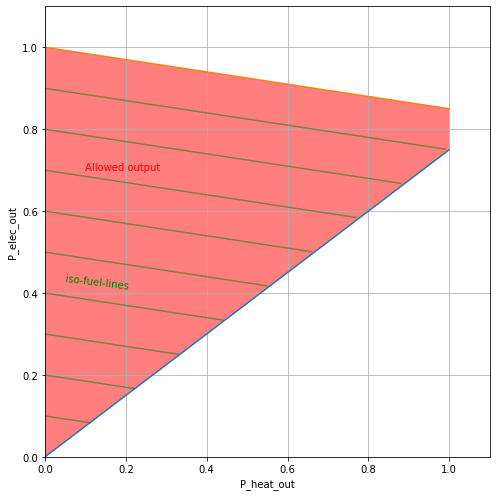

In [38]:
#Graph for the case that max heat output equals max electric output

fig,ax = plt.subplots(1,1)

fig.set_size_inches((7,7))

t = 0.01

ph = np.arange(0,1.0001,t)

ax.plot(ph,c_m*ph)

ax.set_xlabel("P_heat_out")

ax.set_ylabel("P_elec_out")

ax.grid(True)

ax.set_xlim([0,1.1])
ax.set_ylim([0,1.1])

ax.text(0.1,0.7,"Allowed output",color="r")

ax.plot(ph,1-c_v*ph)

for i in range(1,10):
    k = 0.1*i
    x = np.arange(0,k/(c_m+c_v),t)
    ax.plot(x,k-c_v*x,color="g",alpha=0.5)
    
ax.text(0.05,0.41,"iso-fuel-lines",color="g",rotation=-7)

ax.fill_between(ph,c_m*ph,1-c_v*ph,facecolor="r",alpha=0.5)

fig.tight_layout()

if False:
    fig.savefig("chp_feasible.pdf",transparent=True)

## Now do optimisation

In [4]:
heat = True
chp = True


network = pypsa.Network()

network.set_snapshots(pd.date_range("2016-01-01 00:00","2016-01-01 03:00",freq="H"))

network.add("Bus",
            "0",
            carrier="AC")

network.add("Bus",
            "0 gas",
            carrier="gas")

network.add("Carrier",
            "wind")

network.add("Carrier",
            "gas",
            co2_emissions=0.2)

network.add("GlobalConstraint",
            "co2_limit",
            sense="<=",
            constant=0.)


network.add("Generator",
            "wind turbine",
            bus="0",
            carrier="wind",
            p_nom_extendable=True,
            p_max_pu=[0.,0.2,0.7,0.4],
            capital_cost=1000)

network.add("Load",
            "load",
            bus="0",
            p_set=5.)



network.add("Link",
            "P2G",
            bus0="0",
            bus1="0 gas",
            efficiency=0.6,
            capital_cost=1000,
            p_nom_extendable=True)

network.add("Link",
            "generator",
            bus0="0 gas",
            bus1="0",
            efficiency=0.468,
            capital_cost=400,
            p_nom_extendable=True)


network.add("Store",
            "gas depot",
            bus="0 gas",
            e_cyclic=True,
            e_nom_extendable=True)


if heat:
    
    network.add("Bus",
            "0 heat",
            carrier="heat")
    
    network.add("Carrier",
               "heat")

    network.add("Load",
            "heat load",
            bus="0 heat",
            p_set=10.)

    network.add("Link",
            "boiler",
            bus0="0 gas",
            bus1="0 heat",
            efficiency=0.9,
            capital_cost=300,
            p_nom_extendable=True)
    
    network.add("Store",
            "water tank",
            bus="0 heat",
            e_cyclic=True,
            e_nom_extendable=True)    


if heat and chp:

    #Guarantees ISO fuel lines, i.e. fuel consumption p_b0 + p_g0 = constant along p_g1 + c_v p_b1 = constant
    network.links.at["boiler","efficiency"] = network.links.at["generator","efficiency"]/c_v
    
    def extra_functionality(network,snapshots):

        #Guarantees heat output and electric output nominal powers are proportional
        network.model.chp_nom = Constraint(rule=lambda model : network.links.at["generator","efficiency"]*nom_r*model.link_p_nom["generator"] == network.links.at["boiler","efficiency"]*model.link_p_nom["boiler"])

        #Guarantees c_m p_b1  \leq p_g1
        def backpressure(model,snapshot):
            return c_m*network.links.at["boiler","efficiency"]*model.link_p["boiler",snapshot] <= network.links.at["generator","efficiency"]*model.link_p["generator",snapshot] 
        
        network.model.backpressure = Constraint(list(snapshots),rule=backpressure)
        
        #Guarantees p_g1 +c_v p_b1 \leq p_g1_nom
        def top_iso_fuel_line(model,snapshot):
            return model.link_p["boiler",snapshot] + model.link_p["generator",snapshot] <= model.link_p_nom["generator"]
        
        network.model.top_iso_fuel_line = Constraint(list(snapshots),rule=top_iso_fuel_line)
        
else:
    extra_functionality = None

In [5]:
network.lopf(network.snapshots, extra_functionality=extra_functionality)
print("Objective:",network.objective)

INFO:pypsa.pf:Slack bus for sub-network 0 is 0
INFO:pypsa.pf:Slack bus for sub-network 1 is 0 gas
INFO:pypsa.pf:Slack bus for sub-network 2 is 0 heat
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


Objective: 162253.999561692


In [6]:
network.loads_t.p

,load,heat load
2016-01-01 00:00:00,5.0,10.0
2016-01-01 01:00:00,5.0,10.0
2016-01-01 02:00:00,5.0,10.0
2016-01-01 03:00:00,5.0,10.0


In [7]:
network.links.p_nom_opt

P2G          58.648915
generator    28.490028
boiler        4.273504
Name: p_nom_opt, dtype: float64

In [8]:
#CHP is dimensioned by the heat demand met in three hours when no wind
4*10./3/network.links.at["boiler","efficiency"]

4.2735042735042734

In [9]:
#elec is set by the heat demand
28.490028*0.15

4.2735042

In [10]:
network.links_t["p0"]

,P2G,generator,boiler
2016-01-01 00:00:00,5.000000,21.367521,4.273504
2016-01-01 01:00:00,23.185404,21.367521,4.273504
2016-01-01 02:00:00,58.648915,0.000000,0.000000
2016-01-01 03:00:00,41.370809,21.367521,4.273504


In [11]:
network.links_t["p1"]

,P2G,generator,boiler
2016-01-01 00:00:00,-3.000000,-10.0,-13.333333
2016-01-01 01:00:00,-13.911243,-10.0,-13.333333
2016-01-01 02:00:00,-35.189349,-0.0,-0.000000
2016-01-01 03:00:00,-24.822485,-10.0,-13.333333


In [12]:
print(pd.DataFrame({attr: network.stores_t[attr]["gas depot"] for attr in ["p","e"]}))

                             e          p
2016-01-01 00:00:00  11.729783  22.641026
2016-01-01 01:00:00   0.000000  11.729783
2016-01-01 02:00:00  35.189349 -35.189349
2016-01-01 03:00:00  34.370809   0.818540


In [13]:
if heat:
    print(pd.DataFrame({attr: network.stores_t[attr]["water tank"] for attr in ["p","e"]}))
    print(pd.DataFrame({attr: network.links_t[attr]["boiler"] for attr in ["p0","p1"]}))

                             e          p
2016-01-01 00:00:00   6.666667  -3.333333
2016-01-01 01:00:00  10.000000  -3.333333
2016-01-01 02:00:00   0.000000  10.000000
2016-01-01 03:00:00   3.333333  -3.333333
                           p0         p1
2016-01-01 00:00:00  4.273504 -13.333333
2016-01-01 01:00:00  4.273504 -13.333333
2016-01-01 02:00:00  0.000000  -0.000000
2016-01-01 03:00:00  4.273504 -13.333333


In [14]:
print(network.stores.loc["gas depot"])

attribute
bus                   0 gas
type                       
e_nom                     0
e_nom_extendable       True
e_nom_min                 0
e_nom_max               inf
e_min_pu                  0
e_max_pu                  1
e_initial                 0
e_cyclic               True
p_set                     0
q_set                     0
sign                      1
marginal_cost             0
capital_cost              0
standing_loss             0
e_nom_opt           35.1893
Name: gas depot, dtype: object


In [15]:
print(network.generators.loc["wind turbine"])

attribute
bus                          0
control                  Slack
type                          
p_nom                        0
p_nom_extendable          True
p_nom_min                    0
p_nom_max                  inf
p_min_pu                     0
p_max_pu                     1
p_set                        0
q_set                        0
sign                         1
carrier                   wind
marginal_cost                0
capital_cost              1000
efficiency                   1
committable              False
start_up_cost                0
shut_down_cost               0
min_up_time                  0
min_down_time                0
initial_status               1
ramp_limit_up              NaN
ramp_limit_down            NaN
ramp_limit_start_up          1
ramp_limit_shut_down         1
p_nom_opt               90.927
Name: wind turbine, dtype: object


In [16]:
print(network.links.p_nom_opt)

P2G          58.648915
generator    28.490028
boiler        4.273504
Name: p_nom_opt, dtype: float64


In [17]:
#Calculate the overall efficiency of the CHP

eta_elec = network.links.at["generator","efficiency"]

r = 1/c_m

#P_h = r*P_e

print((1+r)/((1/eta_elec)*(1+c_v*r)))

0.91
